# 데이터 관련

In [ ]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

###  Google Drive Mount 

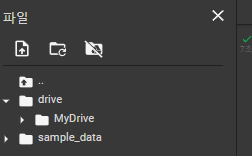

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzip dataset
- 구글 드라이브에 데이터를 저장할 시 I/O 병목으로 인해 train 속도가 느릴 수 있습니다.
- 코랩의 content 디렉토리 아래에 데이터의 압축을 풀어 사용하시기 바랍니다

In [ ]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_train.zip
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_val.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Font_npy_100_val/Sample026/img026-00236.npy  
  inflating: Font_npy_100_val/Sample026/img026-00593.npy  
  inflating: Font_npy_100_val/Sample026/img026-00587.npy  
  inflating: Font_npy_100_val/Sample026/img026-00752.npy  
  inflating: Font_npy_100_val/Sample026/img026-00020.npy  
  inflating: Font_npy_100_val/Sample026/img026-00746.npy  
  inflating: Font_npy_100_val/Sample026/img026-00331.npy  
  inflating: Font_npy_100_val/Sample026/img026-01013.npy  
  inflating: Font_npy_100_val/Sample026/img026-00696.npy  
  inflating: Font_npy_100_val/Sample026/img026-00682.npy  
  inflating: Font_npy_100_val/Sample026/img026-00866.npy  
  inflating: Font_npy_100_val/Sample026/img026-00133.npy  
  inflating: Font_npy_100_val/Sample026/img026-00867.npy  
  inflating: Font_npy_100_val/Sample026/img026-00873.npy  
  inflating: Font_npy_100_val/Sample026/img026-00087.npy  
  inflating: Font_npy_100_val/Sample026/img026-00736.npy  
  inflating: Font_np

### Custom dataset & dataloader

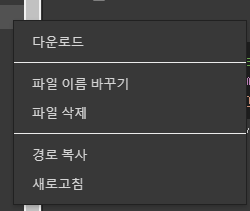

In [ ]:
# Check GPU Configuration
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Fri Dec  9 07:44:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# FIX SEED
def fix_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

fix_seed(42)

In [ ]:
# load dataset
import glob
class MyDataset(Dataset):
    def __init__(self, npy_dir): # image file (*.npy) 들을 포함하고 있는 디렉토리 경로 npy_dir 로 받아야, 
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 

    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)



train_data = MyDataset("/content/Font_npy_100_train") # unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
valid_data = MyDataset("/content/Font_npy_100_val")
test_data = MyDataset("/content/Font_npy_90_test")

print(len(train_data))
print(len(valid_data))
print(len(test_data))

37232
7800
0


In [ ]:
# define dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size,
                                           shuffle=False)


# check dataloader
image, label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


In [ ]:
num_classes = 53
in_channel = 1 
max_pool_kernel = 2  
learning_rate = 0.001
num_epochs = 23

hidden_size = 256
num_layers = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=53):
        super(CNN, self).__init__()

        # 1*100*100
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        # 16*50*50
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        # 32*25*25
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        # 64*12*12
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        # 128*6*6
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=max_pool_kernel)
        )
        # 256*3*3

        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=256*3*3, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = F.relu(x)
        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
######## Train ########

import time
from tqdm import tqdm
total_step = len(train_loader) 
total_loss = [] 
model.train()

start = time.time()
for epoch in range(num_epochs):
  epoch_loss = []
  for i, (img, label) in enumerate(train_loader):
    # Assign Tensors to Configures Devices (gpu)
    img, label = img.to(device), label.to(device)

    # Forward propagation
    img = img.float()
    outputs = model(img)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.detach().cpu().numpy())

    # Print Loss
    if i % 10000 == 0 or (i+1)==len(train_loader): 
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  total_loss.append(np.mean(epoch_loss))
  print(f"epoch{i} loss: {np.mean(epoch_loss)}")

end = time.time()
duration = end - start
print("Training takes {:.2f}minutes".format(duration/60))

Epoch [1/23], Step [1/745], Loss: 3.9699
Epoch [1/23], Step [745/745], Loss: 0.2004
epoch744 loss: 0.8323830962181091
Epoch [2/23], Step [1/745], Loss: 0.2392
Epoch [2/23], Step [745/745], Loss: 0.1136
epoch744 loss: 0.3095317780971527
Epoch [3/23], Step [1/745], Loss: 0.2403
Epoch [3/23], Step [745/745], Loss: 0.2735
epoch744 loss: 0.2364969402551651
Epoch [4/23], Step [1/745], Loss: 0.0917
Epoch [4/23], Step [745/745], Loss: 0.5394
epoch744 loss: 0.18904446065425873
Epoch [5/23], Step [1/745], Loss: 0.2296
Epoch [5/23], Step [745/745], Loss: 0.4185
epoch744 loss: 0.15705333650112152
Epoch [6/23], Step [1/745], Loss: 0.1200
Epoch [6/23], Step [745/745], Loss: 0.0510
epoch744 loss: 0.13313300907611847
Epoch [7/23], Step [1/745], Loss: 0.2901
Epoch [7/23], Step [745/745], Loss: 0.0282
epoch744 loss: 0.1206040233373642
Epoch [8/23], Step [1/745], Loss: 0.0561
Epoch [8/23], Step [745/745], Loss: 0.0378
epoch744 loss: 0.10671337693929672
Epoch [9/23], Step [1/745], Loss: 0.0569
Epoch [9/23

In [ ]:
torch.save(model.state_dict(),"20171218.pth")

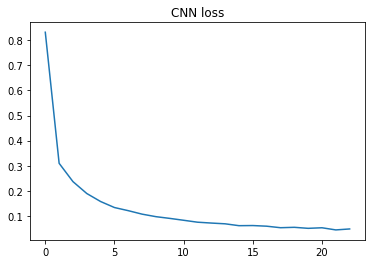

In [ ]:
plt.plot(total_loss)
plt.title("CNN loss")
plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

valid_model = CNN().to(device)
valid_model.load_state_dict(torch.load('20171218.pth'))

valid_model.eval()
with torch.no_grad():
  correct = 0
  
  for image, label in valid_loader:
    image = image.to(device)
    label = label.to(device)
    out = valid_model(image)
    _, pred = torch.max(out.data, 1)
    correct += (pred == label).sum().item()

  print('Accuracy of the last_model network on the {} valid images: {} %'.\
       format(len(valid_data), 100 * correct / len(valid_data)))

Accuracy of the last_model network on the 7800 valid images: 96.87179487179488 %


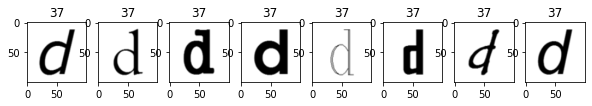

In [ ]:
# visualize data
# character - encoded_label dict , 데이터 확인해보고 싶을 때 참조
label_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17,
'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'P': 24, 'Q': 25, 
'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 
'Z': 34, 'a': 35, 'b': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 
'i': 42, 'j': 43, 'm': 44, 'n': 45, 'o': 46, 'q': 47, 'r': 48, 't': 49, 'u': 50, 'y': 51}

# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+1200][0].squeeze(), cmap = "gray")
    plt.title(dataset[i+1200][1])

image_show(train_data, 8)